### load the CMIP5 rcp85 RAW files and do some data cleaning

* lots of trouble with dates till 2300
* can't fix the off-by-12hours trouble when the dates get re-interpreted as cftime

In [88]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from glob import glob
import os, sys
sys.path.append("/home2/nhn2/py_packages")
from myplots.cplot import my_contourf
from tqdm import tqdm
from mytools.LG_xarray_tools import xarray_trend
import pandas as pd

In [94]:
# lets get started using the 1x1 degree 40 models that Haibo has on kage:

recompute = False

scenario ='historical'
#scenario ='rcp85'
var = 'ts'

path = '/net/stregone/home/naomi/Raws/histPrcp85/*/'+scenario+'/atmos/mon/'+var

files = glob(path + '/r1i1p1/*.nc')
models=[]
for file in files:
    models += [file.split("/")[-7]]

umodels = sorted(list(set(models)))


In [95]:
m_units=[]
m=0
for model in umodels:
    path = '/net/stregone/home/naomi/Raws/histPrcp85/'+model+'/'+scenario+'/atmos/mon/'+var
    files = sorted(glob(path + '/r1i1p1/*.nc'))
    file1 = files[0]   
    dss = xr.open_dataset(file1,decode_times=False,autoclose=True)
    fstr = '{:2} {:18} units = {:40} \t calendar =  {:.20}'
    m_units += [dss.time.attrs['units']]
    print(fstr.format(m,model,dss.time.attrs['units'],dss.time.attrs['calendar']))
    m += 1

 0 ACCESS1-0          units = days since 0001-01-01                    	 calendar =  proleptic_gregorian
 1 ACCESS1-3          units = days since 0001-01-01                    	 calendar =  proleptic_gregorian
 2 BNU-ESM            units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 3 CCSM4              units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 4 CESM1-BGC          units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 5 CESM1-CAM5         units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 6 CESM1-CAM5-1-FV2   units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 7 CESM1-FASTCHEM     units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 8 CESM1-WACCM        units = days since 1850-01-01 00:00:00           	 calendar =  noleap
 9 CMCC-CESM          units = days since 1850-1-1                      	 calendar =  standard
10 CMCC-CM            units = days since 1850-1-1   

In [96]:
from ingrid.times import to_pandas, enso2date
ds = []
good_models = []
num = 0
size = 0
#for model in tqdm(umodels):
for model,units in zip(umodels,m_units):
    path = '/net/stregone/home/naomi/Raws/histPrcp85/'+model+'/'+scenario+'/atmos/mon/'+var
    files = sorted(glob(path + '/r1i1p1/*.nc'))
    num_files = np.shape(files)[0]   
    if num_files:
        dss = xr.open_mfdataset(files,decode_times=True,autoclose=True)
        #xr.decode_cf(dss)
        nt = dss.time.shape[0]
        size = size + dss.nbytes
        #dss = dss.isel(time=list(np.arange(0,min(nt,1200))))
        ds += [dss[var]]
        good_models += [model]
        dx = (dss.lon[1]-dss.lon[0]).values
        dy = (dss.lat[1]-dss.lat[0]).values
        tfirst = str(dss.time[0].values)
        tlast = str(dss.time[-1].values)
        fstr = '{:2g}: {:18} num_files={:2g}, {:.19} to {:.19}, dx={:04.2f}, dy={:04.2f}, {:5.1f}Mb'
        print(fstr.format(num,model,num_files,tfirst,tlast,dx,dy,dss.nbytes/ 1e6))
        num += 1
    else:
        print('no files available')
print(size/ 1e9,'Gb')

 0: ACCESS1-0          num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.88, dy=1.25, 208.5Mb
 1: ACCESS1-3          num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.88, dy=1.25, 208.5Mb
 2: BNU-ESM            num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=2.81, dy=2.77,  61.4Mb
 3: CCSM4              num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.25, dy=0.94, 414.1Mb
 4: CESM1-BGC          num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.25, dy=0.94, 414.1Mb
 5: CESM1-CAM5         num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.25, dy=0.94, 414.1Mb
 6: CESM1-CAM5-1-FV2   num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=2.50, dy=1.89, 103.6Mb
 7: CESM1-FASTCHEM     num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=1.25, dy=0.94, 414.1Mb
 8: CESM1-WACCM        num_files= 1, 1850-01-16T12:00:00 to 2005-12-16T12:00:00, dx=2.50, dy=1.89, 103.6Mb
 9: CMCC-CESM          num_files=32, 

In [98]:
# ok, lets first fix the 360_day models 
from datetime import datetime
num = 0
for dss in ds:
    #t1 = np.datetime64(dss.time[0].values)
    t1 = dss.time[0].values
    #if not 'datetime64' in str(type(t1)):
    
        
    print(num,t1,type(t1))
    #print(dss.time)
    if 'T00:00:00' in str(t1):
        print(dss.time.values,type(dss.time.values[0]))
        if 'Timestamp' in str(type(dss.time.values[0])):
            dt = pd.to_datetime(dss.time.values)
            #ds[num]['time'] = np.datetime64(dt) + np.timedelta64(12, 'h')
            ds[num]['time'] = dt + np.timedelta64(12, 'h')
        else:
            ds[num]['time'] = dss.time.values + np.timedelta64(12, 'h')
    fstr = '{:18} start = {:20}'
    print(fstr.format(umodels[num],ds[num].time[0].values))
    num += 1

0 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
ACCESS1-0          start = 1850-01-16T12:00:00.000000000
1 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
ACCESS1-3          start = 1850-01-16T12:00:00.000000000
2 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
BNU-ESM            start = 1850-01-16T12:00:00.000000000
3 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CCSM4              start = 1850-01-16T12:00:00.000000000
4 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CESM1-BGC          start = 1850-01-16T12:00:00.000000000
5 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CESM1-CAM5         start = 1850-01-16T12:00:00.000000000
6 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CESM1-CAM5-1-FV2   start = 1850-01-16T12:00:00.000000000
7 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CESM1-FASTCHEM     start = 1850-01-16T12:00:00.000000000
8 1850-01-16T12:00:00.000000000 <class 'numpy.datetime64'>
CESM1-WACCM  

In [99]:
# now we will interpolate in (lon,lat)
import xesmf as xe
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89,89, 2)),
                     'lon': (['lon'], np.arange(-179,179,2)),
                    })
regridder = list(map(lambda x: 
                xe.Regridder(x, ds_out, 'bilinear',
                periodic=True, reuse_weights=True ), ds))

Reuse existing file: bilinear_145x192_89x179_peri.nc
Reuse existing file: bilinear_145x192_89x179_peri.nc
Reuse existing file: bilinear_64x128_89x179_peri.nc
Reuse existing file: bilinear_192x288_89x179_peri.nc
Reuse existing file: bilinear_192x288_89x179_peri.nc
Reuse existing file: bilinear_192x288_89x179_peri.nc
Reuse existing file: bilinear_96x144_89x179_peri.nc
Reuse existing file: bilinear_192x288_89x179_peri.nc
Reuse existing file: bilinear_96x144_89x179_peri.nc
Reuse existing file: bilinear_48x96_89x179_peri.nc
Reuse existing file: bilinear_240x480_89x179_peri.nc
Reuse existing file: bilinear_96x192_89x179_peri.nc
Reuse existing file: bilinear_128x256_89x179_peri.nc
Reuse existing file: bilinear_96x192_89x179_peri.nc
Reuse existing file: bilinear_64x128_89x179_peri.nc
Reuse existing file: bilinear_64x128_89x179_peri.nc
Reuse existing file: bilinear_60x128_89x179_peri.nc
Reuse existing file: bilinear_108x128_89x179_peri.nc
Reuse existing file: bilinear_64x128_89x179_peri.nc
Reus

In [100]:
ts_2x2 = list(map(lambda x,y: 
                  x(y.sel(time=slice('1961-01-16', '2005-12-16'))),
                  regridder,ds))

In [101]:
dsall = xr.concat(ts_2x2,dim='model')
dsall.nbytes / 1e9,'Gb'

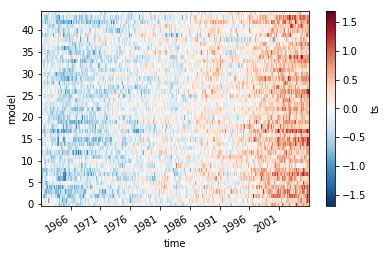

In [103]:
dclim = dsall.groupby('time.month').mean(dim='time')
danom = dsall.groupby('time.month') - dclim
del danom['month']
danom.mean(['lat','lon']).plot()